We are making clusters out of the embedded data. These clusters represent the data of each individual for categorization purposes

In [1]:
from utils import save_face_list, extract_frames
from face_extraction import process_image, check_face
from facenet_pytorch import MTCNN
import torch
import cv2
from main_extract_faces import process_movies
from main_unsupervised import find_best_number_of_clusters
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import os
import shutil
import plots
import augmentation
import main_embed
import cluster_dataframe
import embed



C:\Users\ningw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Video File Handling Code Explanation

This code snippet is responsible for loading and verifying the accessibility of a specific video file using OpenCV (`cv2`).

In [2]:
#Make sure you are in the right directory
os.getcwd()

'c:\\Users\\ningw\\Desktop\\Assignment3\\KTA3'

In [3]:
# Input and output file extensions for video files and images
input_extension = '.mp4'
output_extension = '.png'
samples_per_second = 10
padding_x = 10
padding_y = 10
min_confidence = 0.5

# List of movie names for training and testing
MOVIE_TRAINING_LIST = ['New_Kids_ABC', 'New_Kids_Fussballspiel', 
                       'New_Kids_Turbo_Tankstation', 'New_Kids_Nitro_Peter_lemonade_720']
MOVIE_TEST_LIST = ['Test']

# Movie folder (unchanged, retains absolute path)
MOVIE_FOLDER = "C:\\Users\\ningw\\Desktop\\"  # Path where video files are stored

# Define current directory variable
current_directory = os.getcwd()  # Dynamically set to the current working directory

# Define paths using the current directory variable
FACES_FOLDER_TRAINING = f"{current_directory}\\face_folder\\"
FACES_FOLDER_TEST = f"{current_directory}\\face_folder_test\\"

OUTPUT_FOLDER_RESULTS_TRAIN = f"{current_directory}\\results\\"
RESULTS_NAME_TRAIN = "results.csv"
RESULTS_CSV_TRAIN = f"{OUTPUT_FOLDER_RESULTS_TRAIN}\\{RESULTS_NAME_TRAIN}"

OUTPUT_FOLDER_RESULTS_TEST = f"{current_directory}\\results_test\\"
RESULTS_NAME_TEST = "test_results.csv"
RESULTS_CSV_TEST = f"{OUTPUT_FOLDER_RESULTS_TEST}\\{RESULTS_NAME_TEST}"

KMEANS_OUTPUT_FOLDER = f"{current_directory}\\KMEANS_OUTPUT\\"
CLUSTER_MODEL_PATH = f"{KMEANS_OUTPUT_FOLDER}\\kmeans.pkl"

# List of all directories
directories = [FACES_FOLDER_TRAINING, FACES_FOLDER_TEST, 
               OUTPUT_FOLDER_RESULTS_TRAIN, OUTPUT_FOLDER_RESULTS_TEST, 
               KMEANS_OUTPUT_FOLDER]

# Check if each directory exists, and create it if it doesn't
for path in directories:
    if not os.path.isdir(path):  # Check if the directory exists
        os.makedirs(path, exist_ok=True)  # Create the directory if it doesn't exist
        print(f"Checked/Created directory: {path}")  # Confirm creation of the directory
    else:
        print(f"Directory already exists: {path}")  # Confirm the directory already exists

Checked/Created directory: c:\Users\ningw\Desktop\Assignment3\KTA3\face_folder\
Checked/Created directory: c:\Users\ningw\Desktop\Assignment3\KTA3\face_folder_test\
Checked/Created directory: c:\Users\ningw\Desktop\Assignment3\KTA3\results\
Checked/Created directory: c:\Users\ningw\Desktop\Assignment3\KTA3\results_test\
Checked/Created directory: c:\Users\ningw\Desktop\Assignment3\KTA3\KMEANS_OUTPUT\


### Video File Handling Code Explanation

This code snippet is responsible for loading and verifying the accessibility of a specific video file using OpenCV (`cv2`).

In [4]:
# OpenCV's VideoCapture is initialized with the path to a video file.
cap = cv2.VideoCapture(MOVIE_FOLDER + MOVIE_TRAINING_LIST[1] + '.mp4')  # Construct the full file path using MOVIE_FOLDER and the second video name in the list.

# Check if the video file has been successfully opened.
if not cap.isOpened():  # .isOpened() returns False if the video file cannot be accessed.
    print("Error: Cannot open video file.")  # Print an error message if the video file cannot be opened.
else:
    print("Video file opened successfully!")  # Print a success message if the video file is opened correctly.

# Release the resources associated with the VideoCapture object.
cap.release()  # It's important to release the VideoCapture object to free resources and avoid memory leaks.

Video file opened successfully!


### Calling the `process_movies` Function with Defined Variables

The `process_movies` function is designed to process a list of movies, extract faces from their frames, and save the extracted faces to a specified folder.

In [5]:
# Call the function using the defined variables
process_movies(
    movie_list=MOVIE_TRAINING_LIST,
    movie_folder=MOVIE_FOLDER,
    faces_folder=FACES_FOLDER_TRAINING,
    input_extension=input_extension,
    output_extension=output_extension,
    samples_per_second=samples_per_second,
    padding_x=padding_x,
    padding_y=padding_y,
    min_confidence=min_confidence
)


Processing: New_Kids_ABC.mp4
Start extracting frames
Successfully captured 204 frames
Saving faces...
Processing: New_Kids_Fussballspiel.mp4
Start extracting frames
Successfully captured 464 frames
Saving faces...
Processing: New_Kids_Turbo_Tankstation.mp4
Start extracting frames
Successfully captured 440 frames
Saving faces...
Processing: New_Kids_Nitro_Peter_lemonade_720.mp4
Start extracting frames
Successfully captured 104 frames
Saving faces...


### Calling the `embed` Function for the training

The `embed` function is designed to process training face images stored in a folder, compute their embeddings using a neural network, and save the resulting embeddings to a CSV file in the specified output folder. 

In [6]:
main_embed.embed(FACES_FOLDER_TRAINING, OUTPUT_FOLDER_RESULTS_TRAIN,RESULTS_NAME_TRAIN)

New_Kids_ABC_0.png
New_Kids_ABC_1.png
New_Kids_ABC_10.png
New_Kids_ABC_100.png
New_Kids_ABC_101.png
New_Kids_ABC_102.png
New_Kids_ABC_103.png
New_Kids_ABC_104.png
New_Kids_ABC_105.png
New_Kids_ABC_106.png
New_Kids_ABC_11.png
New_Kids_ABC_12.png
New_Kids_ABC_13.png
New_Kids_ABC_14.png
New_Kids_ABC_15.png
New_Kids_ABC_16.png
New_Kids_ABC_17.png
New_Kids_ABC_18.png
New_Kids_ABC_19.png
New_Kids_ABC_2.png
New_Kids_ABC_20.png
New_Kids_ABC_21.png
New_Kids_ABC_22.png
New_Kids_ABC_23.png
New_Kids_ABC_24.png
New_Kids_ABC_25.png
New_Kids_ABC_26.png
New_Kids_ABC_27.png
New_Kids_ABC_28.png
New_Kids_ABC_29.png
New_Kids_ABC_3.png
New_Kids_ABC_30.png
New_Kids_ABC_31.png
New_Kids_ABC_32.png
New_Kids_ABC_33.png
New_Kids_ABC_34.png
New_Kids_ABC_35.png
New_Kids_ABC_36.png
New_Kids_ABC_37.png
New_Kids_ABC_38.png
New_Kids_ABC_39.png
New_Kids_ABC_4.png
New_Kids_ABC_40.png
New_Kids_ABC_41.png
New_Kids_ABC_42.png
New_Kids_ABC_43.png
New_Kids_ABC_44.png
New_Kids_ABC_45.png
New_Kids_ABC_46.png
New_Kids_ABC_47.pn

### Choosing the Optimal Number of Clusters: Calinski-Harabasz vs. Silhouette

In our clustering process, we evaluated two different methods to determine the optimal number of clusters: **Silhouette Score** and **Calinski-Harabasz Score**. We opted for the Calinski since it performed better


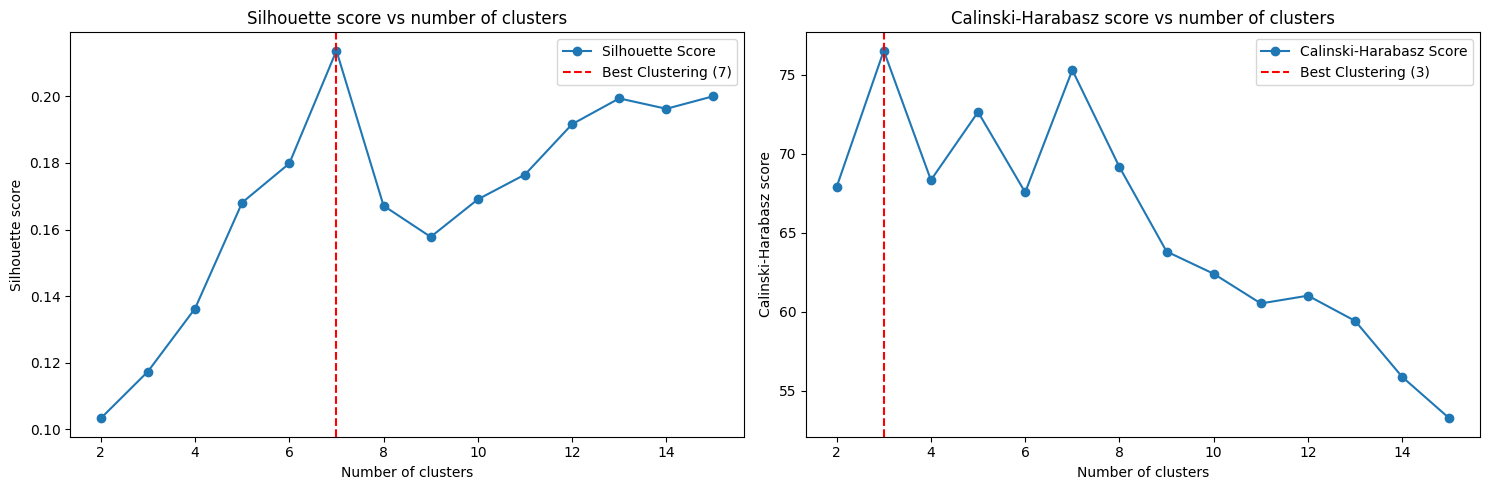

In [7]:
best_clusters_silhouette, best_clusters_calinski = find_best_number_of_clusters(RESULTS_CSV_TRAIN)
cluster_choice = best_clusters_calinski

We do the same now for our testing data

In [8]:
# Function call for testing movies
process_movies(
    movie_list=MOVIE_TEST_LIST,
    movie_folder=MOVIE_FOLDER,
    faces_folder=FACES_FOLDER_TEST,
    input_extension=input_extension,
    output_extension=output_extension,
    samples_per_second=samples_per_second,
    padding_x=padding_x,
    padding_y=padding_y,
    min_confidence=min_confidence
)


Processing: Test.mp4
Start extracting frames
Successfully captured 521 frames
Saving faces...


In [9]:
main_embed.embed(FACES_FOLDER_TEST,OUTPUT_FOLDER_RESULTS_TEST,RESULTS_NAME_TEST)

Test_0.png
Test_1.png
Test_10.png
Test_100.png
Test_101.png
Test_102.png
Test_103.png
Test_104.png
Test_105.png
Test_106.png
Test_107.png
Test_108.png
Test_109.png
Test_11.png
Test_110.png
Test_111.png
Test_112.png
Test_113.png
Test_114.png
Test_115.png
Test_116.png
Test_117.png
Test_118.png
Test_119.png
Test_12.png
Test_120.png
Test_121.png
Test_122.png
Test_123.png
Test_124.png
Test_125.png
Test_126.png
Test_127.png
Test_128.png
Test_129.png
Test_13.png
Test_130.png
Test_131.png
Test_132.png
Test_133.png
Test_134.png
Test_135.png
Test_136.png
Test_137.png
Test_138.png
Test_139.png
Test_14.png
Test_140.png
Test_141.png
Test_142.png
Test_143.png
Test_144.png
Test_145.png
Test_146.png
Test_147.png
Test_148.png
Test_149.png
Test_15.png
Test_150.png
Test_151.png
Test_152.png
Test_153.png
Test_154.png
Test_155.png
Test_156.png
Test_157.png
Test_158.png
Test_159.png
Test_16.png
Test_160.png
Test_161.png
Test_162.png
Test_163.png
Test_164.png
Test_165.png
Test_166.png
Test_167.png
Test_168.p

# Exploring the Outcomes

After successfully processing the embeddings and organizing images based on clusters and outliers, we are now starting to explore the results of our analysis. 


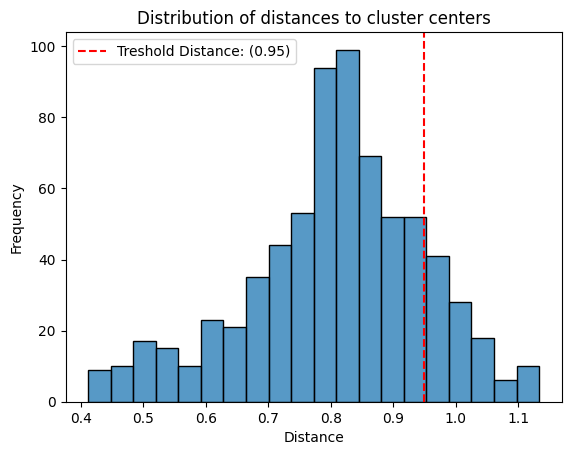

In [10]:
# Load training embeddings from the CSV file
train_embeddings_df = pd.read_csv(RESULTS_CSV_TRAIN)  # Read embeddings for training faces into a DataFrame.
trains_embeddings = train_embeddings_df.T.values  # Transpose the DataFrame and convert it to NumPy array format.

# Load testing embeddings from the CSV file
test_embeddings_df = pd.read_csv(RESULTS_CSV_TEST)  # Read embeddings for test faces into a DataFrame.
test_embeddings = test_embeddings_df.T.values  # Transpose the DataFrame and convert it to NumPy array format.

# Perform KMeans clustering on the training embeddings
kmeans = KMeans(random_state=0, n_clusters=cluster_choice).fit(trains_embeddings)  # Fit KMeans model using the training embeddings.
labels = kmeans.labels_  # Assign cluster labels to the training embeddings.

# Calculate distances from each point to its closest cluster center
distances_train = pairwise_distances_argmin_min(trains_embeddings, kmeans.cluster_centers_)[1]  # Compute distances from each embedding to its cluster center.

# Determine the 85th percentile distance as the threshold for outliers
threshold_distance_85 = np.percentile(distances_train, 85)  # Set the threshold based on the 85th percentile of distances.

# Plot histogram of distances and the 85th percentile threshold
plots.plot_histplot_percentile(distances_train, threshold_distance_85)  # Generate a histogram to visualize distances.

# Remove embeddings considered outliers based on the threshold
for i, file_name in enumerate(train_embeddings_df.columns):  # Iterate over each column (embedding) in the DataFrame.
    if distances_train[i] > threshold_distance_85:  # Check if the distance exceeds the outlier threshold.
        train_embeddings_df.drop(file_name, axis='columns', inplace=True)  # Drop the outlier column from the DataFrame.

# Recompute embeddings array after removing outliers
trains_embeddings = train_embeddings_df.T.values  # Update the embeddings array after removing outliers.

# Re-run KMeans clustering with a higher maximum iteration limit
kmeans = KMeans(random_state=0, n_clusters=cluster_choice, max_iter=600).fit(trains_embeddings)  # Fit the updated training embeddings to KMeans.
labels = kmeans.labels_  # Get updated cluster labels after re-running KMeans.

# Organize images into cluster folders and outlier folders
for i, file_name in enumerate(train_embeddings_df.columns):  # Iterate through each embedding in the DataFrame.
    src_path = os.path.join(FACES_FOLDER_TRAINING, file_name)  # Define the source path of the image.
    
    # Assign the image to the "outliers" folder or its respective cluster folder
    if distances_train[i] > threshold_distance_85:  # Check if the image is an outlier.
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, 'outliers', file_name)  # Set destination to "outliers" folder.
    else:
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, f'cluster_{labels[i]}', file_name)  # Set destination to the corresponding cluster folder.

    # Ensure the destination directory exists before saving the image
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Create the directory if it does not exist.
    shutil.copy(src_path, dst_path)  # Copy the image to the destination path.



Processing Test.mp4
Start extracting frames
Successfully captured 521 frames


c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_presence.loc[cluster, frame_idx] = 1  # Mark presence of cluster in the frame.
c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_presence.loc[cluster, frame_idx] = 1  # Mark presence of cluster in the frame.
c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

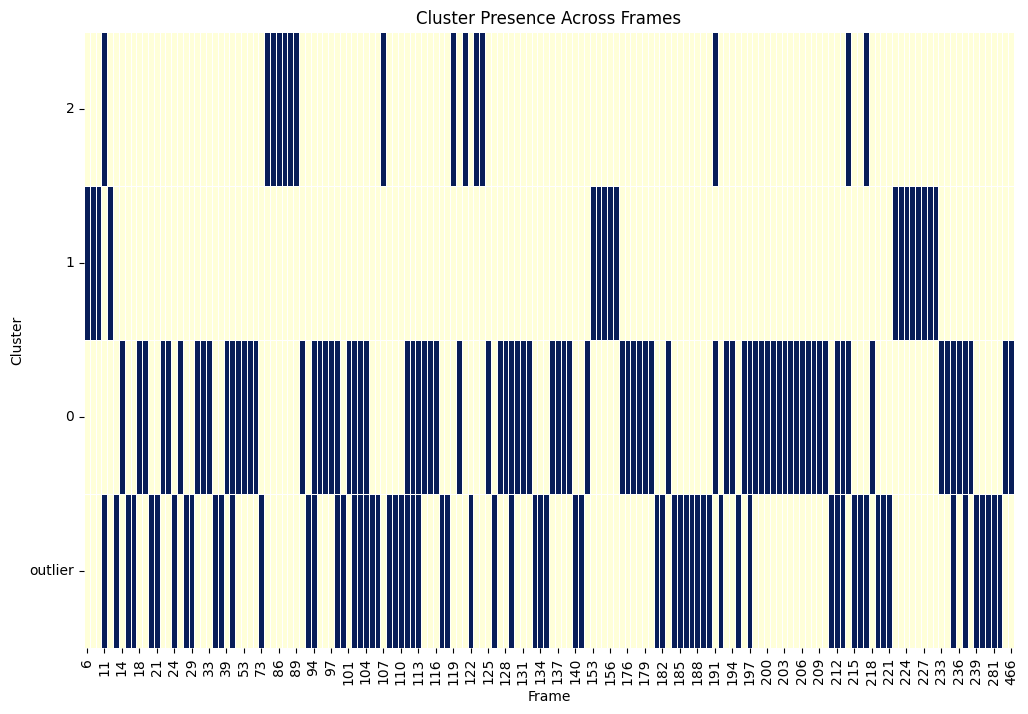

Processing Test.mp4
Start extracting frames
Successfully captured 521 frames


c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_presence.loc[cluster, frame_idx] = 1  # Mark presence of cluster in the frame.
c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_presence.loc[cluster, frame_idx] = 1  # Mark presence of cluster in the frame.
c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

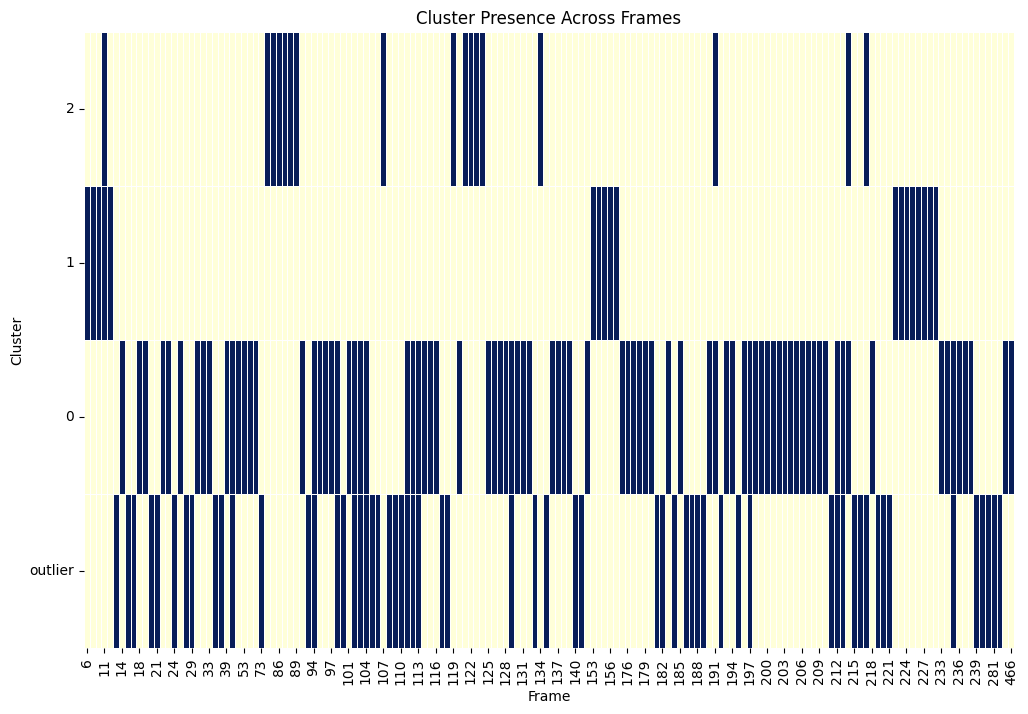

Processing Test.mp4
Start extracting frames
Successfully captured 521 frames


c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_presence.loc[cluster, frame_idx] = 1  # Mark presence of cluster in the frame.
c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_presence.loc[cluster, frame_idx] = 1  # Mark presence of cluster in the frame.
c:\Users\ningw\Desktop\Assignment3\KTA3\cluster_dataframe.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

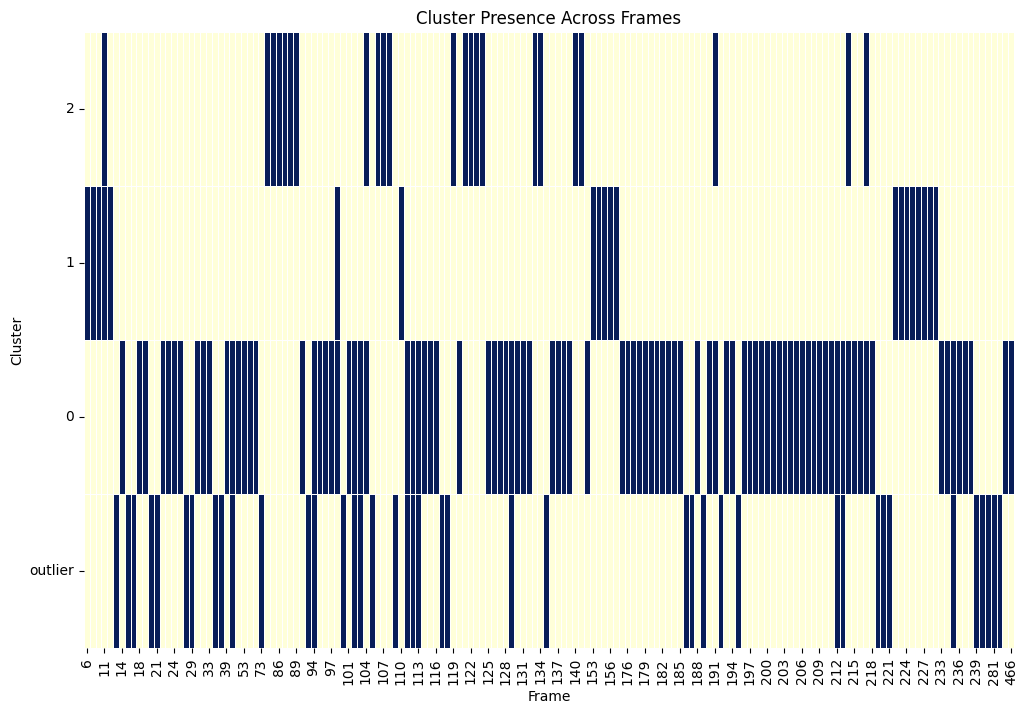

Processing Test.mp4
Start extracting frames
Successfully captured 521 frames


In [ ]:
thresholds = [0.80, 0.85, 0.9, 0.95]
for threshold in thresholds:
    # Calculate the threshold distance for the current percentile
    threshold_distance = np.percentile(distances_train, threshold * 100)      
    clusterdf = cluster_dataframe.process_videos_to_dataframe(MOVIE_TEST_LIST,MOVIE_FOLDER,kmeans, threshold_distance_85=threshold_distance)
    plots.plot_cluster_presence(clusterdf.sort_index(ascending=False)) 


# Performing Image Augmentation to Assess Impact

Image augmentation is a technique used to artificially adjust the dataset by applying transformations such as flipping, rotation, noise addition, or distortion. This helps evaluate the robustness of clustering and embedding models when faced with varied and augmented data.

In [ ]:
augmentation.process_images_with_augmentations(FACES_FOLDER_TEST,'AUGMENTED')

In [ ]:
# Iterate through all folders in the 'AUGMENTED' directory
for folder_name in os.listdir('AUGMENTED'):  # List all items in the 'AUGMENTED' directory.
    folder_path = os.path.join('AUGMENTED', folder_name, '')  # Construct the full path to the current folder.

    if os.path.isdir(folder_path):  # Check if the current item is a directory.
        # Dynamically construct paths for processing the folder
        AUGMENTED_FOLDERS = folder_path  # Set the path of the current folder as the augmented data folder.
        RESULT_NAME_TRAIN = f'embed_{folder_name}.csv'  # Dynamically create a CSV file name based on the folder name.

        # Debugging: Print paths to verify correctness
        print(f"Processing folder: {AUGMENTED_FOLDERS}")  # Print the path of the augmented folder being processed.
        print(f"Output folder: {OUTPUT_FOLDER_RESULTS_TEST}")  # Print the path where the results will be saved.
        print(f"Result file: {RESULT_NAME_TRAIN}")  # Print the name of the result file.

        # Call embedding function to process the augmented data
        main_embed.embed(AUGMENTED_FOLDERS, OUTPUT_FOLDER_RESULTS_TEST, RESULT_NAME_TRAIN)
        # The embedding function processes images in the augmented folder,
        # computes embeddings, and saves the results in the specified output folder as a CSV file.


In [ ]:
thresholds = [0.80, 0.85, 0.9, 0.95]
for threshold in thresholds:
    # Calculate the threshold distance for the current percentile
    threshold_distance = np.percentile(distances_train, threshold * 100)
    
    # Process the test embeddings with the current threshold
    results_df = cluster_dataframe.process_test_embeddings(
        test_embeddings=test_embeddings,
        test_embeddings_df=test_embeddings_df,
        kmeans=kmeans,
        output_folder='recognition-output',
        face_folder_test='face_folder_test',
        threshold=threshold_distance,
        results_output_path = f'test_results_{threshold}.csv',
    )
    
    # Plot actor presence
    plots.plot_actor_presence(results_df, 'Cluster', cluster_choice,f'test_results_{threshold}.csv')


In [ ]:
# Ensure the distorted_result directory exists 
os.makedirs("distorted_result", exist_ok=True)

#voor ieder embeddingbestand wordt clusterin gedaan, afstand bepaald en frequenty gedemonstreerd clustering distance 85
for file_name in os.listdir(OUTPUT_FOLDER_RESULTS_TEST):
    file_path = os.path.join(OUTPUT_FOLDER_RESULTS_TEST, file_name)
    
    # Check if it's a CSV file
    if file_name.endswith('.csv') and os.path.isfile(file_path):
        print(f"Processing file: {file_name}")
        
        # Read the embeddings from the CSV file
        test_embeddings_df = pd.read_csv(file_path)
        test_embeddings = test_embeddings_df.T.values
        print(test_embeddings_df.columns)
        # Process the embeddings and generate results
        results_df = cluster_dataframe.process_test_embeddings(
            test_embeddings=test_embeddings,
            test_embeddings_df=test_embeddings_df,
            kmeans=kmeans,
            output_folder='recognition-output',
            face_folder_test="face_folder_test",
            threshold=threshold_distance_85,
            results_output_path = f"distorted_result\\{file_name}",
        )
        
        # Plot actor presence
        plots.plot_actor_presence(results_df, 'Cluster', cluster_choice,file_name)